In [20]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container {width:70% !important;}</style>"))

# Generative AI Use Case: Summarize Dialogue
Generative AI를 활용한 dialogue summarization(대화 요약) 실험을 진행합니다. 이 실험을 통해서,
- input text(입력 값)이 모델의 output(출력)에 어떤 영향을 주는지를 살펴보고
- 원하는 결과가 나오도록 prompt engineering을 수행해봅니다.

Zero shot, One-shot, Few-shot Inference 를 통해서,
- prompt engineering의 그 첫번째 스텝을 밟아보고,
- prompt engineering이 Large Language Models 생성 결과를 얼마나 개선시킬 수 있는지 확인해봅니다.

# Table of Contents

- [ 1 - Set up Kernel and Required Dependencies](#1)
- [ 2 - Summarize Dialogue without Prompt Engineering](#2)
- [ 3 - Summarize Dialogue with an Instruction Prompt](#3)
  - [ 3.1 - Zero Shot Inference with an Instruction Prompt](#3.1)
  - [ 3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5](#3.2)
- [ 4 - Summarize Dialogue with One Shot and Few Shot Inference](#4)
  - [ 4.1 - One Shot Inference](#4.1)
  - [ 4.2 - Few Shot Inference](#4.2)
- [ 5 - Generative Configuration Parameters for Inference](#5)


<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

Pytorch 와 Hugging Face의 transformer, dataset을 사용하기 위해 패키지를 설치합니다.

In [44]:
# !pip install torch==1.13.1
# !pip install torchdata==0.5.1

# !pip install transformers==4.27.2
# !pip install datasets==2.11.0

### Import package

In [45]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

<a name='2'></a>
## 2 - Summarize Dialogue without Prompt Engineering

Hugging Face의 pre-trained Large Language Model(LLM)을 사용해 대화를 요약해봅시다. 모델은 FLAN-T5를 사용합니다. 이외에도 [여기](https://huggingface.co/docs/transformers/index)에서 Hugging Face `transformers` package의 다양한 모델을 찾아 활용할 수 있습니다.

데이터셋은 [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum)를 사용합니다. 약 10,000개의 대화셋을 포함하고 있고 사람이 직접 요약 및 주제를 레이블 처리한 human-labeled dataset 입니다.

In [46]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

Found cached dataset csv (/home/ahjeong/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-391706c81424fc80/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 3/3 [00:00<00:00, 262.53it/s]


Dialogue 데이터셋을 확인해봅니다.

In [47]:
print(dataset.shape)
print(dataset['train'])

{'train': (12460, 4), 'test': (1500, 4), 'validation': (500, 4)}
Dataset({
    features: ['id', 'dialogue', 'summary', 'topic'],
    num_rows: 12460
})


In [48]:
example_indices = [10, 40]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
---------------------------------------------------------------------------------------------------
BASEL

Dialogue Summary를 실험하기 위해 [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5)를 불러옵니다.
<br>
이때, 'AutoModelForSeq2SeqLM' 클래스의 'from_pretrained()' 함수를 사용해 불러옵니다.

In [49]:
model_name='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

### Tokenization

대화 데이터셋의 Text가 LLM의 encoding, decoding을 거치려면 '토큰화'가 필요합니다. 토큰화는 sentences or texts를 작은 단위로 쪼개주는 과정을 말합니다.

`AutoTokenizer.from_pretrained()` 의 첫번째 parameter로 모델 이름을 넣어줘 토큰화를 진행할 수 있습니다. `use_fast` parameter는 좀 더 빠른 토큰화를 진행합니다.

In [50]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

tokenizer의 encode, decode 함수를 사용해서 어떻게 토큰화 되는지 확인할 수 있습니다.

In [51]:
sentence = "What is the tokenization?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0], 
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

ENCODED SENTENCE:
tensor([  363,    19,     8, 14145,  1707,    58,     1])

DECODED SENTENCE:
What is the tokenization?


### Summarize a dialogue without prompt engineering

In [52]:
for i, index in enumerate(example_indices):
    
    # test 셋의 dialgue와 summary를 가져옵니다.
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
    
    inputs = tokenizer(dialogue, return_tensors='pt')
    
    # 모델이 생성한 결과를 tokenizer.decode를 통해 텍스트로 변환합니다.
    # model(FLAN-T5)에 intput을 넣어줍니다.
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
---------------------------------------------------------------------------------------------------
BASELIN

말이 되긴하지만 우리가 원하는 답변은 아직 아닙니다. 여기서 프롬프트 엔지니어링을 시도해볼 수 있습니다.

<a name='3'></a>
## 3 - Summarize Dialogue with an Instruction Prompt

<a name='3.1'></a>
### 3.1 - Zero Shot Inference with an Instruction Prompt

Dialogue를 Descriptive Instruction으로 감싸고 생성 결과를 살펴봅니다.

In [53]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
    """
    
    # Dialogue 만 넣는 것 대신에 Prompt와 함께 넣어줍니다.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

Summary:
    
----------------------------------------------------

Zero-shot 결과 이전보다 나아졌지만 더 자세한 뉘앙스는 파악하지 못했습니다.

<a name='3.2'></a>
### 3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5

이번에는 다른 prompt를 활용해서 Zero shot을 진행해봅니다. 

FLAN-T5는 특정 task에 대한 많은 prompt templates를 가지고 있습니다. [pre-built FLAN-T5 prompts](https://github.com/google-research/FLAN/blob/main/flan/v2/templates.py)을 참고하면 다양한 Zero-shot Prompt를 확인할 수 있습니다.

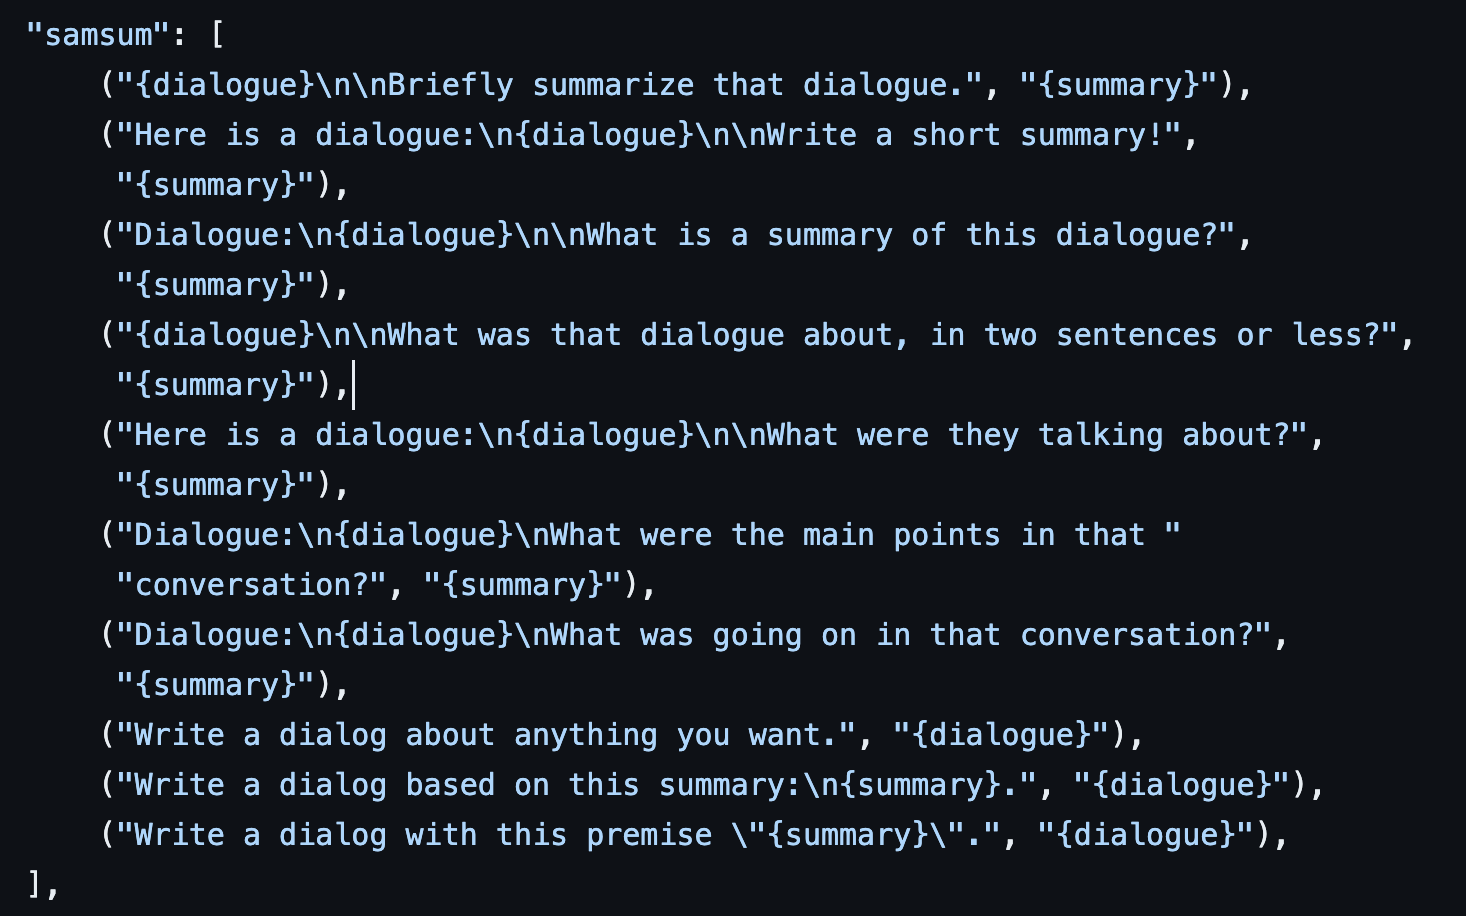


In [54]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
        
    # 이번에는 다른 Prompt를 사용해서 넘겨줍니다.    
    prompt = f"""
Dialogue:

{dialogue}

What was going on?
"""

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Dialogue:

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

What was going on?

--------------------------------------------------------------------------

Dialogue 1은 이전과 비슷하고 Dialogue 2는 조금 더 나아진 것 같습니다.

<a name='4'></a>
## 4 - Summarize Dialogue with One Shot and Few Shot Inference
Few-shot Learning에 대한 [this blog from HuggingFace](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api)을 참고하면 좋을 것 같습니다.

<a name='4.1'></a>
### 4.1 - One Shot Inference

- `example_indices_full` : Full examples가 주어지는 prompt 인덱스
- `example_index_to_summarize` : 우리가 얻고자 하는 Dialog 인덱스

In [55]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        
        # 모델에는 Stop sequence가 필요하기 때문에 FLAN-T5모델에도 문장의 끝인 stop sequnece를 prompt에 함께 넣어줍니다. -> '{summary}\n\n\n'
        prompt += f"""
Dialogue:

{dialogue}

What was going on?
{summary}


"""
    # 생성을 얻고자 하는 dialogue index를 넘겨줍니다.
    dialogue = dataset['test'][example_index_to_summarize]['dialogue']
    
    prompt += f"""
Dialogue:

{dialogue}

What was going on?
"""
        
    return prompt

One-shot Inference를 위한 Prompt를 생성

In [56]:
example_indices_full = [10] # 예시도 넣어주는 dialogue
example_index_to_summarize = 40    # 생성을 얻고자하는 dialogue

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Dialogue:

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

What was going on?
#Person1# attends Brian's birthday party. Brian thinks #Person1# looks great and charming.



Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#:

위에서 만든 prompt로 one-shot inference 수행

In [57]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
Tom is late for the train. He has to catch the nine-thirty train.


예시를 1개 넣어주니까 Dialogue 2가 좀 더 자세한 요약을 생성해주었습니다!

<a name='4.2'></a>
### 4.2 - Few Shot Inference

더 많은 예제를 활용해서 Few-shot Inference 실행해보겠습니다.

In [58]:
example_indices_full = [10, 30, 120]
example_index_to_summarize = 40

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

What was going on?
#Person1# attends Brian's birthday party. Brian thinks #Person1# looks great and charming.



Dialogue:

#Person1#: Where are you going for your trip?
#Person2#: I think Hebei is a good place.
#Person1#: But I heard the north of China are experiencing severe sandstorms!
#Person2#: Really?
#Person1#:

In [59]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (771 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
Tom is late for the train. He has to catch the nine-thirty train.


이 경우, few shot은 one-shot 보다 좋은 성능을 얻지 못하거나 비슷한 성능을 보이게됩니다.

Input-context length를 초과하지 않아야 하는데 지금의 경우 512 token을 넘었기 때문에 512 token 이후의 context는 무시되게 되어서 다음의 경고를 만나게 되었습니다.

"Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors
"

<a name='5'></a>
## 5 - Generative Configuration Parameters for Inference

이제 LLM으로 부터 나오는 output을 어떻게 다양하고 창의적이게 출력할 수 있는지 살펴보려고 합니다.

Generative Configuration을 사용해서 좀 더 다양한 output을 출력해봅시다. [Hugging Face Generation documentation](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig)에서 다양한 paramters를 확인할 수 있습니다.

`GenerationConfig` class 를 활용해 쉽게 테스트해볼 수 있습니다. 

In [60]:
# generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        
        # generation configuration을 추가해 모델이 출력하게끔 해봅시다.
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
Tom is late to catch the train to the railway station.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



max_new_tokens가 짧아지면 문장 생성과정에서 뒷부분이 잘릴 수 있어 정확한 답변이 생성되지 않을 수 있습니다. 

do_sample = True, Temperature을 주었을 때 좀 더 다양한 답변이 생성되는 것 같습니다.

이렇게 prompt engineering을 통해 LLM의 다양한 output을 생성해보았습니다. 여기서 특정 Task에 대해 더 나은 답변을 얻기 위해서 LLM의 Fine-tuning이 필요합니다. 😘